In [1]:
# If you run this code on google colab, please use this code instead of the below one.
!wget https://www.physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip
!unzip mit-bih-arrhythmia-database-1.0.0.zip

--2025-07-02 08:26:41--  https://www.physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip
Resolving www.physionet.org (www.physionet.org)... 18.18.42.54
Connecting to www.physionet.org (www.physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77030320 (73M) [application/zip]
Saving to: ‘mit-bih-arrhythmia-database-1.0.0.zip’

mit-bih-arrhythmia- 100%[===================>]  73.46M   484KB/s    in 2m 37s  

2025-07-02 08:29:19 (478 KB/s) - ‘mit-bih-arrhythmia-database-1.0.0.zip’ saved [77030320/77030320]

Archive:  mit-bih-arrhythmia-database-1.0.0.zip
  inflating: mit-bih-arrhythmia-database-1.0.0/100.atr  
  inflating: mit-bih-arrhythmia-database-1.0.0/100.dat  
  inflating: mit-bih-arrhythmia-database-1.0.0/100.hea  
  inflating: mit-bih-arrhythmia-database-1.0.0/100.xws  
  inflating: mit-bih-arrhythmia-database-1.0.0/101.atr  
  inflating: mit-bih-arrhythmia-database-1.0.0/101.dat  
  inflating: mit-bih-a

In [3]:
pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 112.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.0 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.


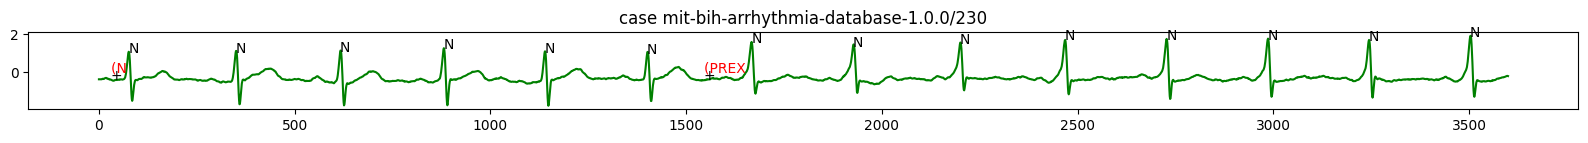

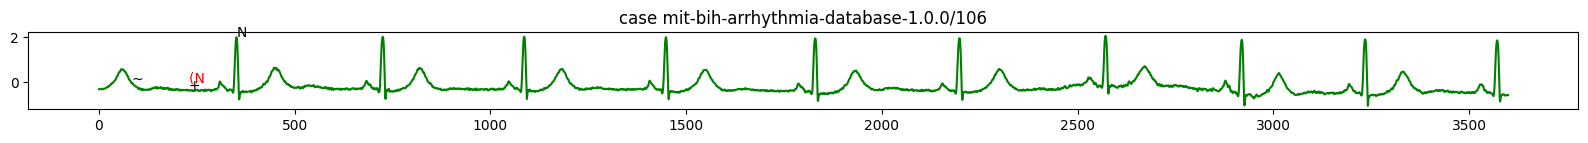

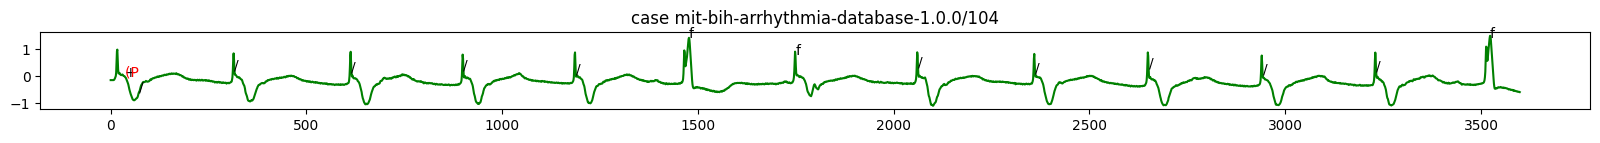

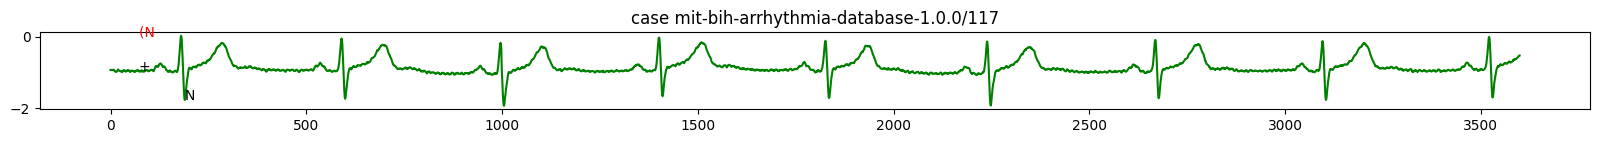

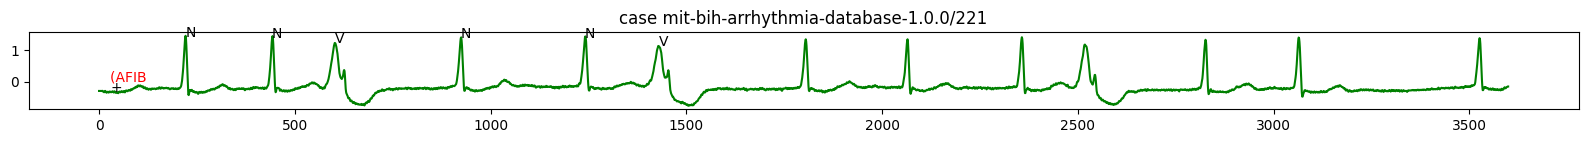

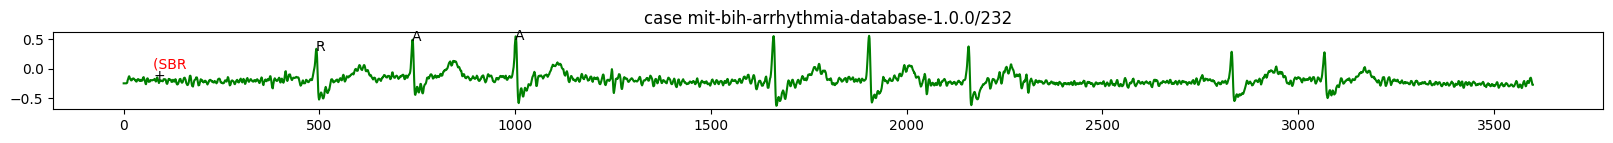

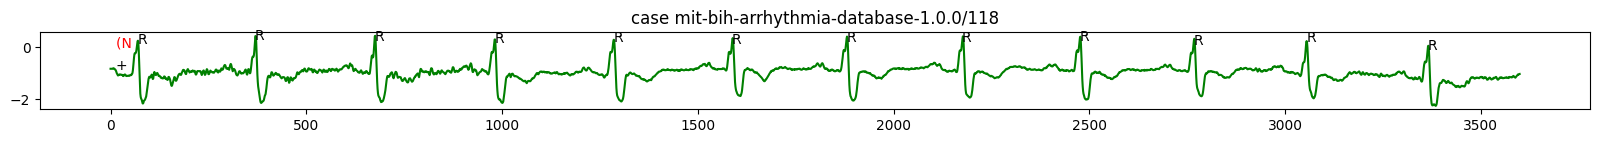

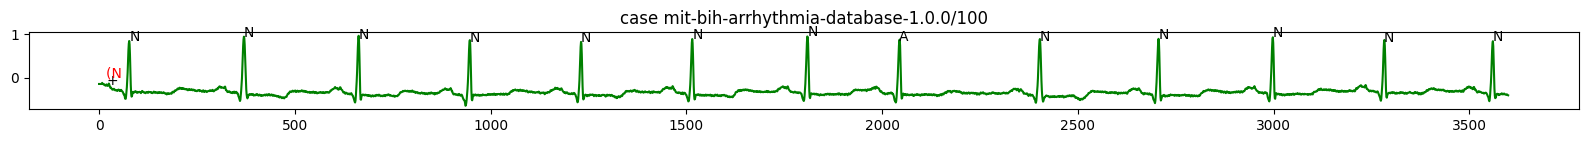

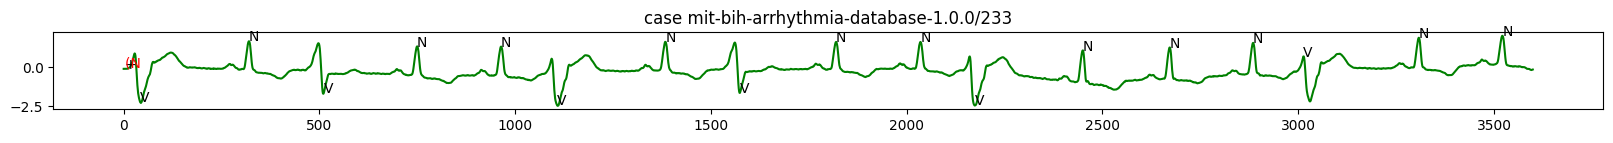

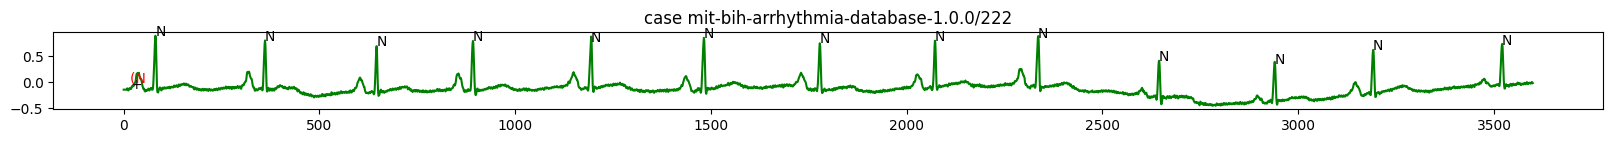

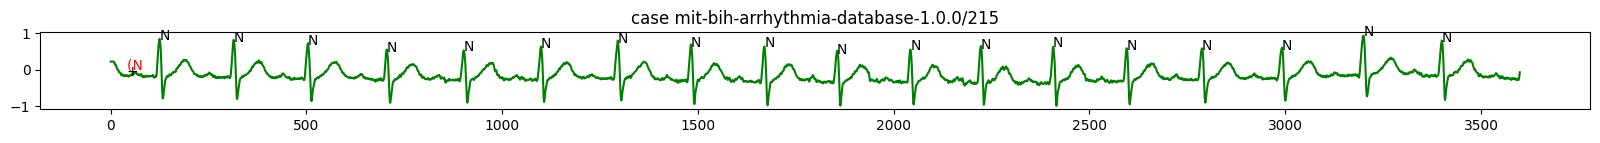

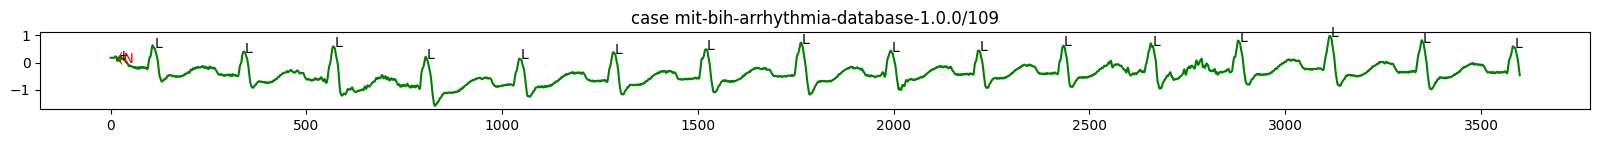

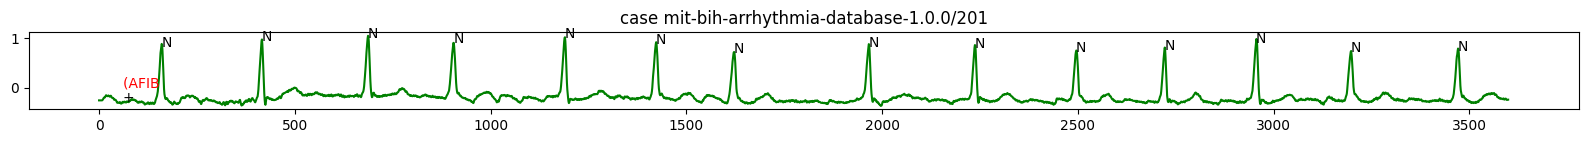

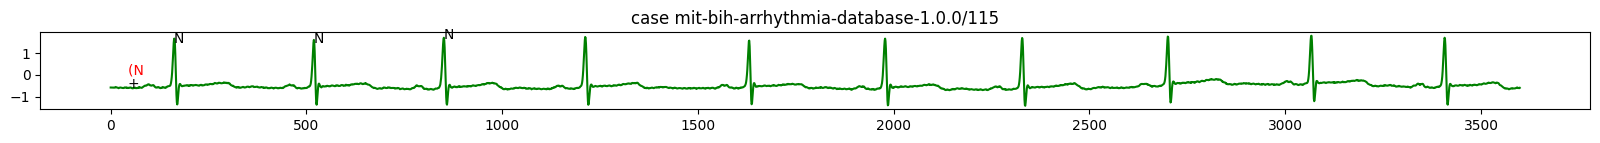

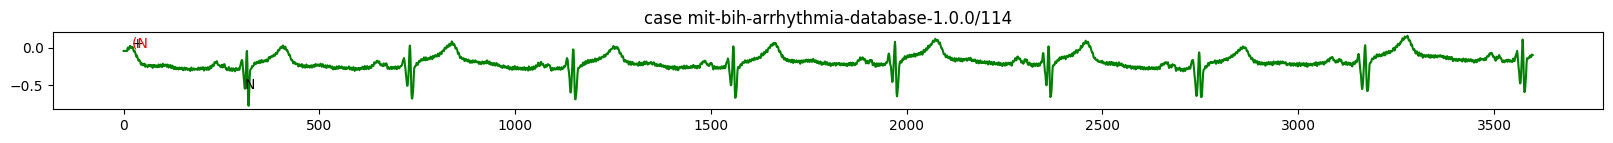

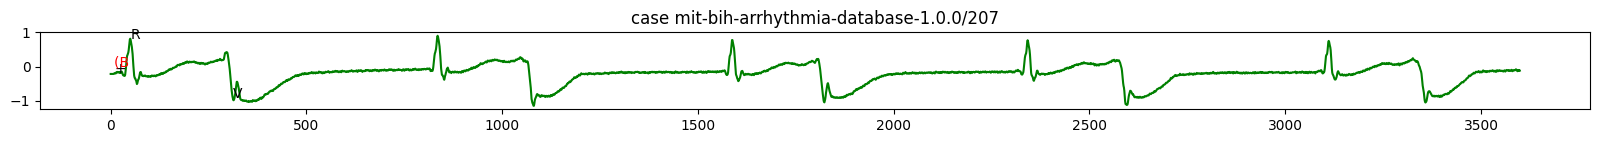

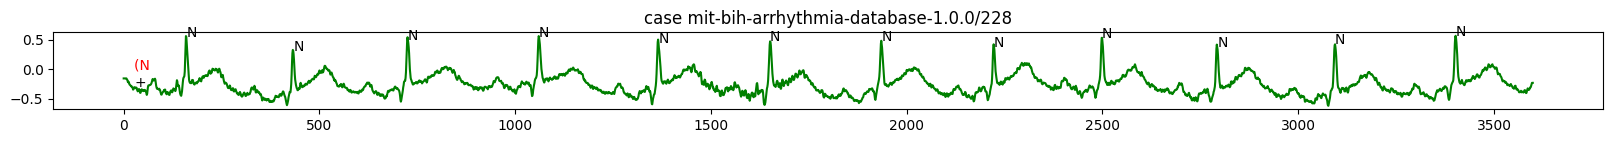

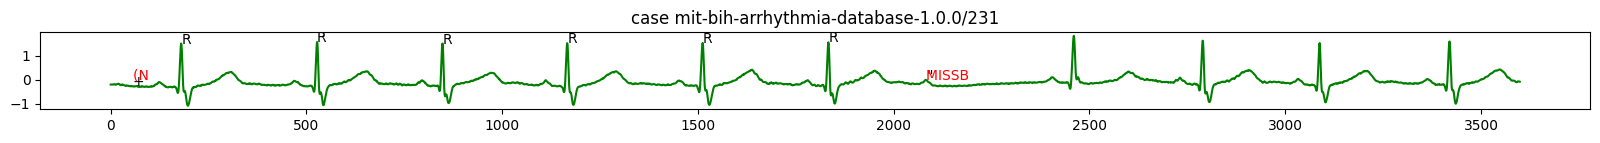

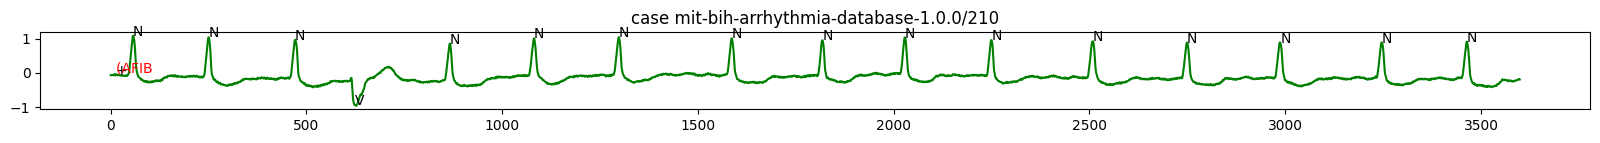

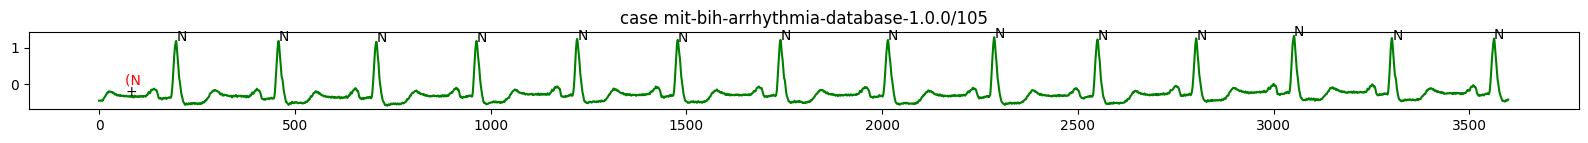

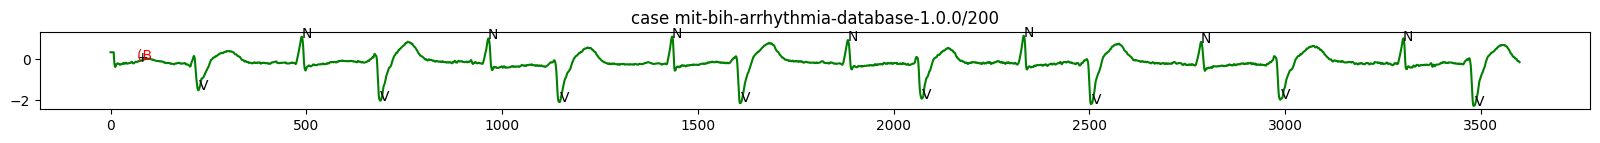

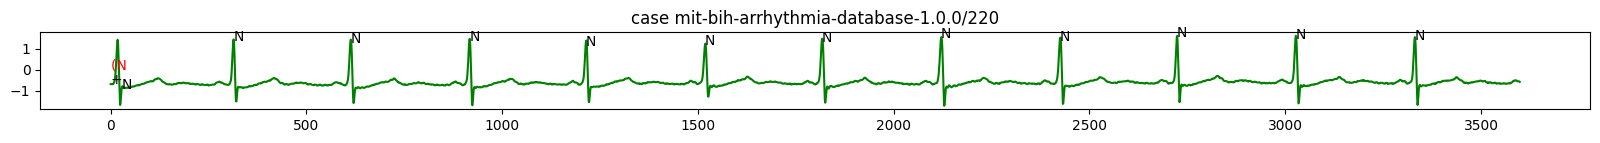

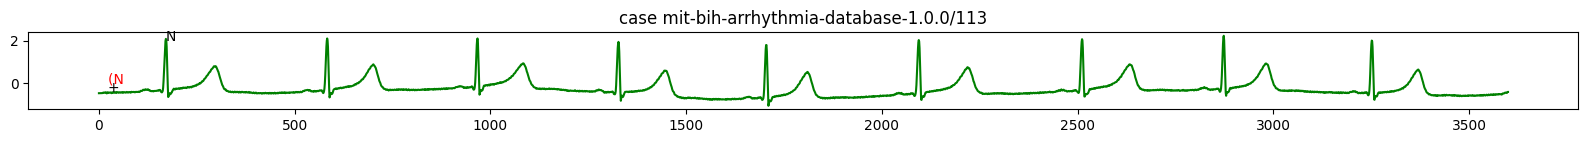

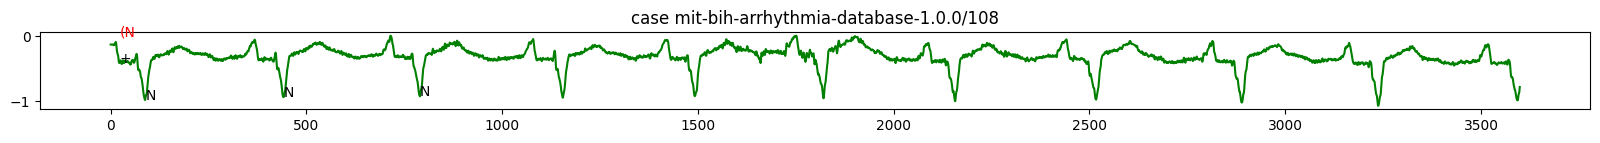

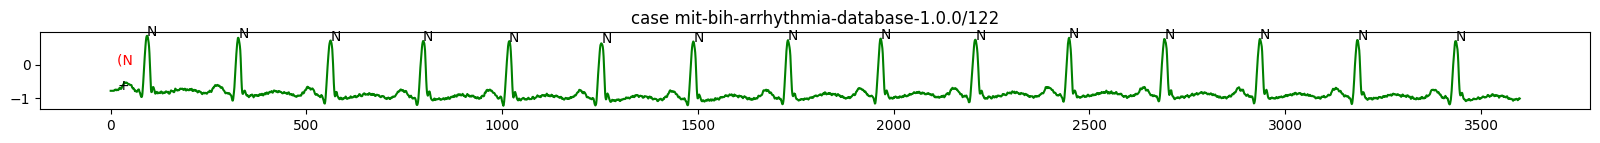

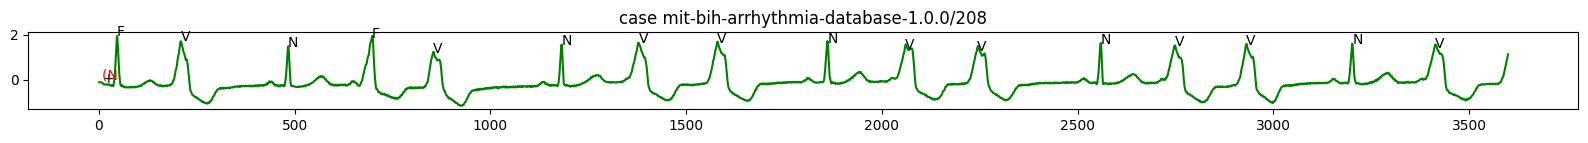

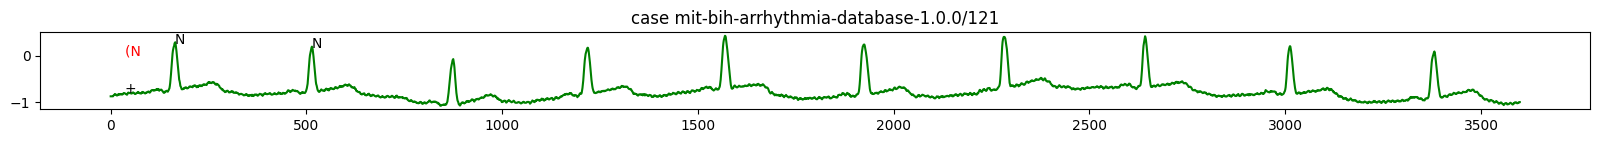

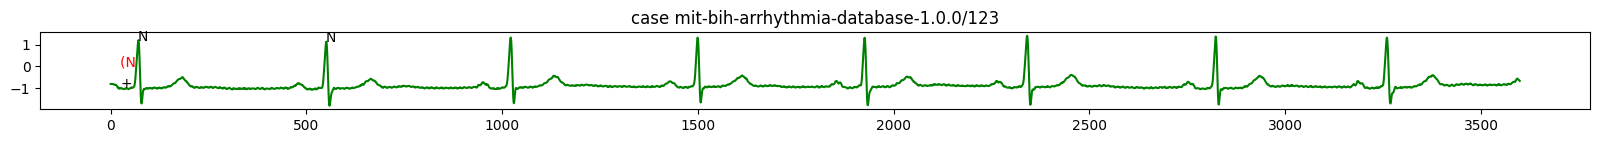

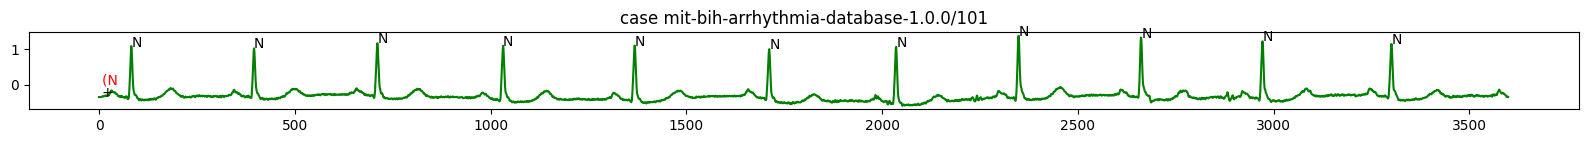

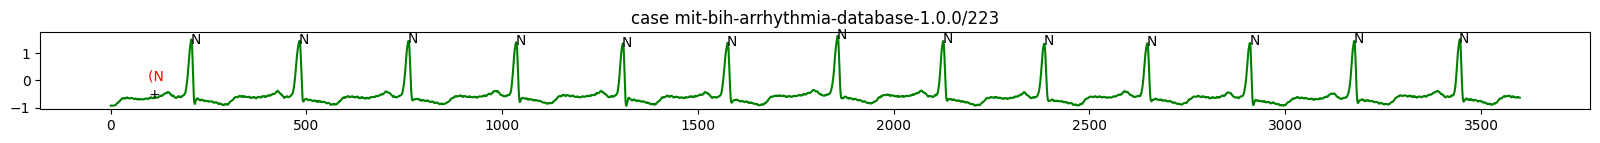

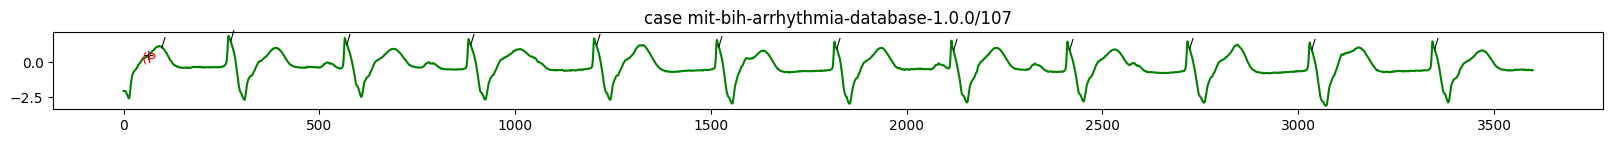

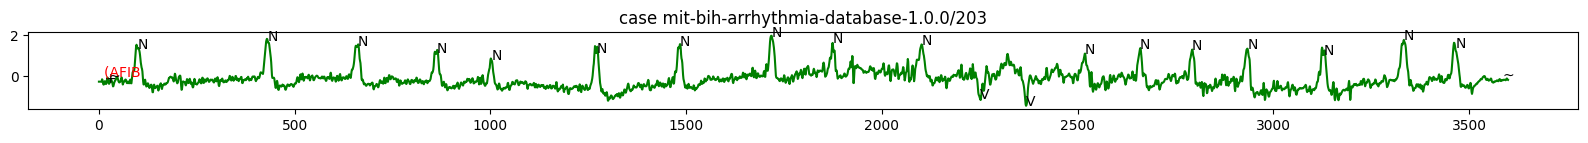

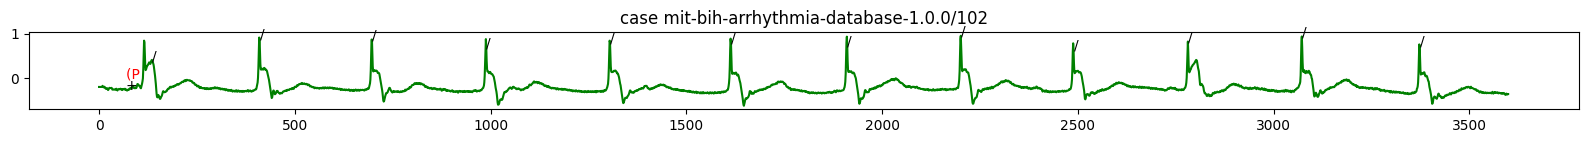

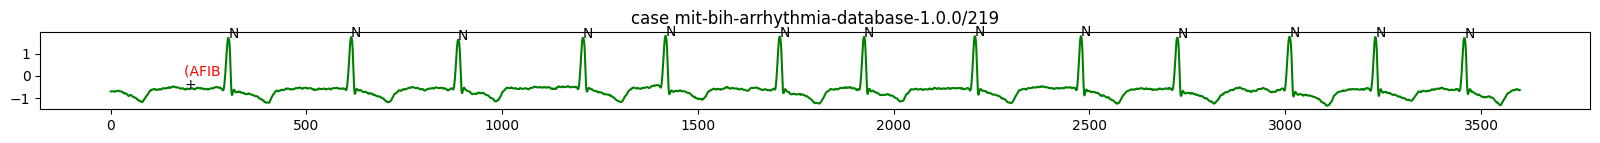

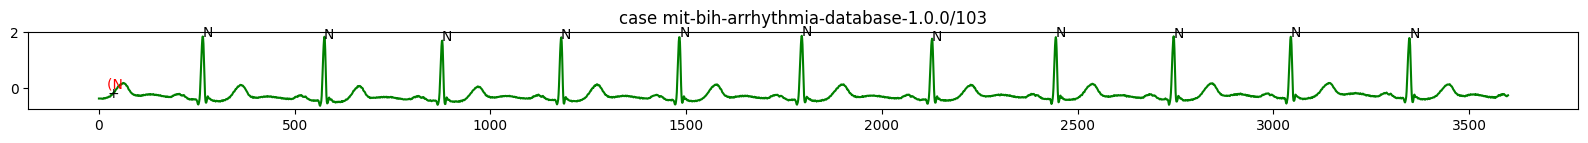

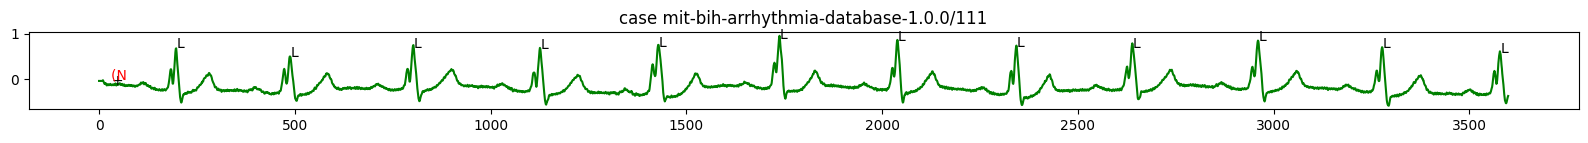

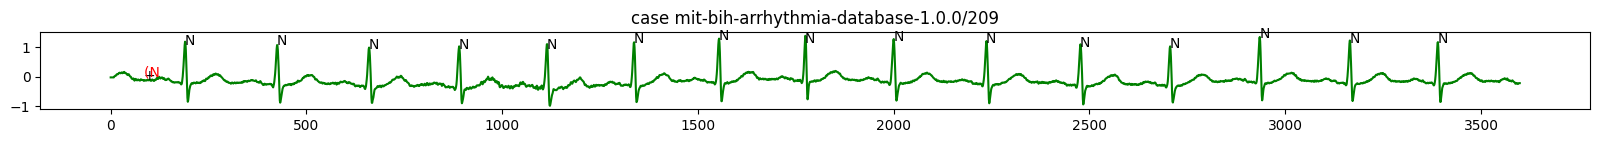

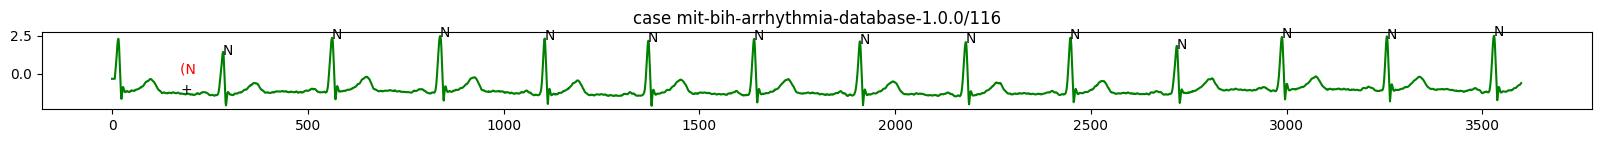

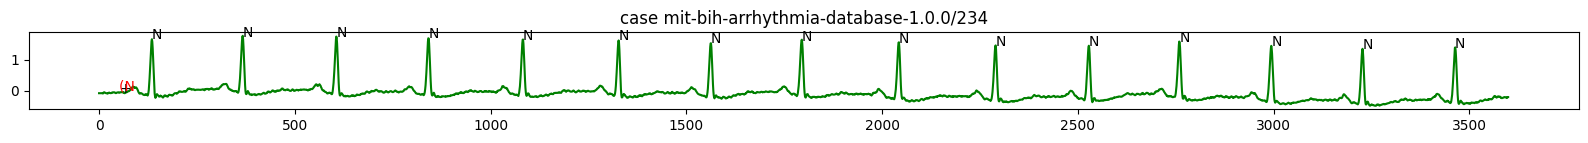

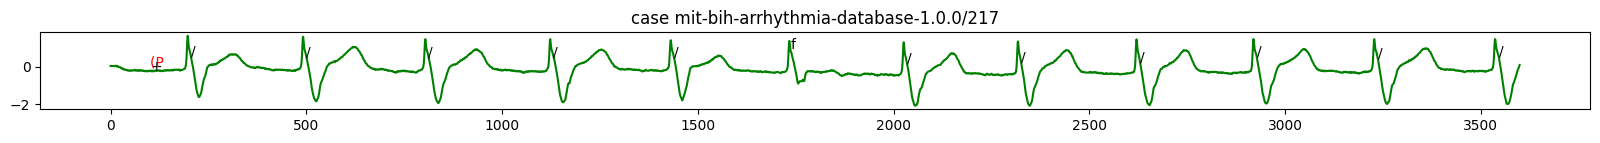

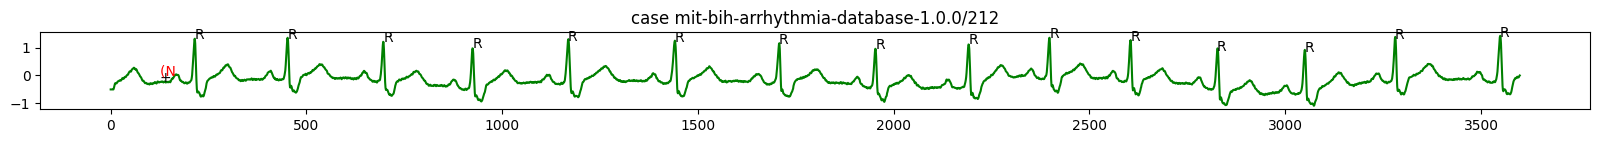

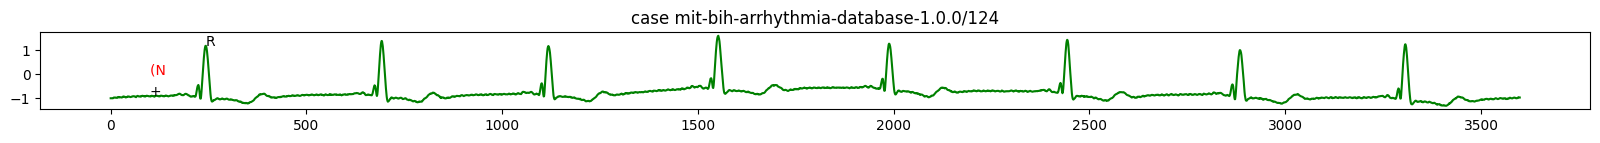

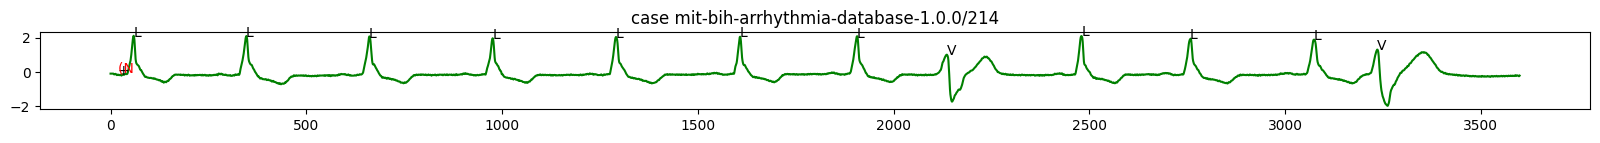

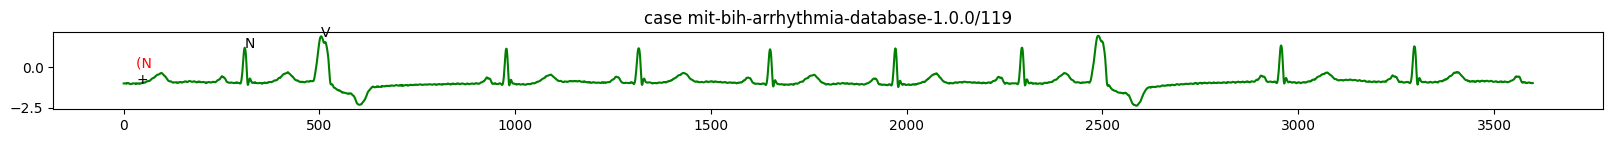

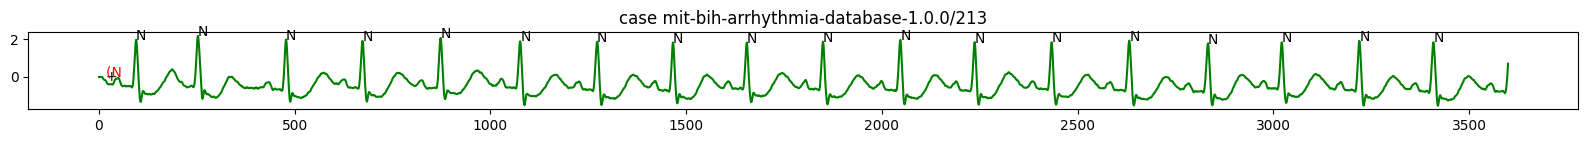

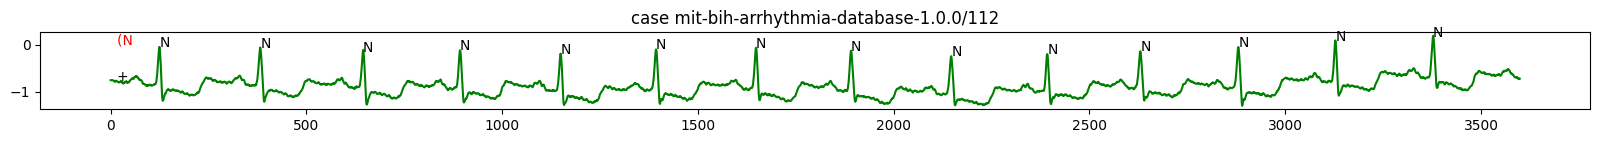

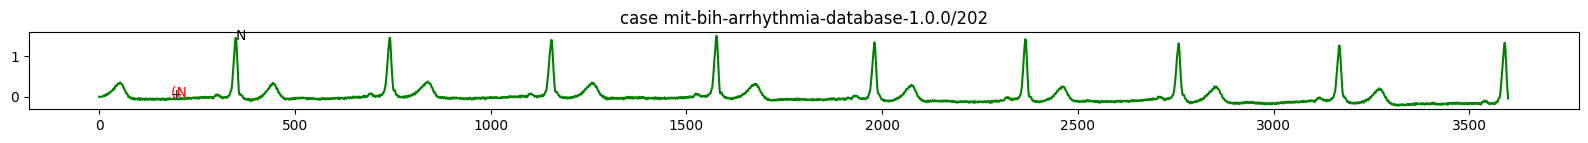

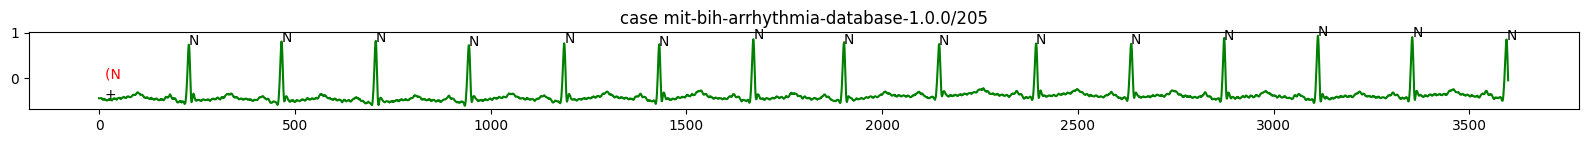

beat_type
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: count, dtype: int64
rhythm_type
         110919
(N          530
MISSB       428
(B          221
(AFIB       107
(PREX       103
(T           83
(VT          61
(P           60
(AFL         45
(NOD         36
(SVTA        26
TS            6
(VFL          6
(BII          5
(IVR          4
(AB           3
PSE           3
(SBR          1
Name: count, dtype: int64


In [4]:
import wfdb
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

SRATE = 360
IPEAK = int(SRATE * 0.3) # PR interval greater than 300 ms is ignored
MAX_BEAT_LEN = int(SRATE * 1) # HR < 12 is ignored
IDIR = 'mit-bih-arrhythmia-database-1.0.0'
DRAW_MAX = SRATE * 10  # 10sec

# Initialize lists to save data statistics
beat_types = []
beat_cnts = []
rhythm_types = []
rhythm_cnts = []
all_beat_samples = []
all_beat_types = []

# Iterate files and load data
for f in os.scandir(IDIR):
    prefix, ext = os.path.splitext(f.path)
    if ext != '.hea':  # each case must have a header
        continue

    # Load sample -> sig_name, p_signal
    samples = wfdb.rdrecord(prefix)

    # Load annotation -> symbol (beat labeling), sample, aux_note (rhythm labeling)
    labels = wfdb.rdann(prefix, 'atr')

    # Update stats
    symbols, cnts = np.unique(labels.symbol, return_counts=True)
    beat_types.extend(symbols)
    beat_cnts.extend(cnts)

    symbols, cnts = np.unique(labels.aux_note, return_counts=True)
    rhythm_types.extend(symbols)
    rhythm_cnts.extend(cnts)

    # Figure
    plt.figure(figsize=(20, 1))
    plt.plot(samples.p_signal[:DRAW_MAX, 0], color='g')
    plt.title(f'case {prefix}')
    lastx = 0
    last_beat_type = ''
    for i in range(len(labels.sample)): # for each label
        x = labels.sample[i]
        y = samples.p_signal[x, 0]

        if labels.chan[i] != 0:
            continue

        beat_type = labels.symbol[i].replace('\x00',' ')
        rhythm_type = labels.aux_note[i].replace('\x00',' ')

        # extract beat samples and type
        if x >= IPEAK:
            if lastx >= IPEAK:
                beat_samples = samples.p_signal[lastx - IPEAK:x - IPEAK, 0]
                if len(beat_samples) > MAX_BEAT_LEN:
                    continue
                # zero pad
                beat_samples = np.pad(beat_samples, (0, MAX_BEAT_LEN - len(beat_samples)))
                all_beat_samples.append(beat_samples)
                all_beat_types.append(last_beat_type)
            last_beat_type = beat_type
            lastx = x

        if x >= DRAW_MAX:
            continue

        plt.text(x, y, beat_type)
        plt.text(x, 0, rhythm_type, color='r')
    plt.show()

# Print the stats
df_beats = pd.DataFrame({'beat_type':beat_types, 'count':beat_cnts})
df_rhythms = pd.DataFrame({'rhythm_type':rhythm_types, 'count':rhythm_cnts})
print(df_beats.groupby('beat_type')['count'].sum().sort_values(ascending=False))
print(df_rhythms.groupby('rhythm_type')['count'].sum().sort_values(ascending=False))